# 대회

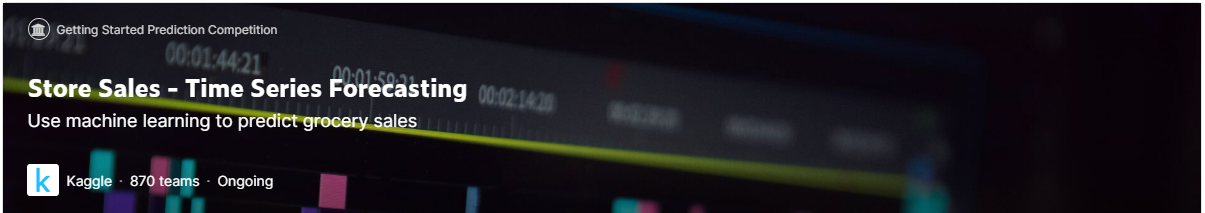

[Store Sales](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

# 분석

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb  3 02:41:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |      3MiB / 15360MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
holidays_events = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/oil.csv')
sample_submission = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/sample_submission.csv')
stores = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/stores.csv')
train = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/test.csv')
transactions = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/transactions.csv')

<font color = "red">date는 한 번에 int형으로 처리할 예정임</font>

## holidays_events

In [6]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [7]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


1. 결측치는 없어보임
2. transferred만 빼고 나머지는 문자형

- 휴일, 경사일 등이 있음
---
<font color = "red">Note </font>

-  transferred day가 휴일인지 아닌지를 잘 모름
  - 실제로 휴일이었는지를 알려면 Transfer로 되어있는 행 찾기
  - 예) 2012-10-09에서 2012-10-12로 Independencia de Guayaquil 휴일이 변경됨

- Bridge 타입은 휴일에 추가된 여분의 휴일임 (더 긴 휴일을 주기 위해)
  - Work Day 타입이 따라오는데 일하는 날이 아니라 Bridge날을 payback 해주는 날임
---
- 크리스마스 주변에 전형적으로 존재하는 추가 휴일이 존재함 (크리스마스 이브)


---
date 외에 다른 특성들을 분석해보겠음

### type

In [8]:
holidays_events['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

Bridge와 Work Day Transfer이 매우 적음
- 전처리가 필요할 것 같음

In [9]:
holidays_events['locale'].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

국립인지 지역적인지 확인해주는 특성

In [10]:
holidays_events['locale_name'].value_counts()

Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: locale_name, dtype: int64

지역 이름이 다양하게 많음

In [11]:
holidays_events['description'].value_counts()

Carnaval                              10
Fundacion de Cuenca                    7
Fundacion de Ibarra                    7
Fundacion de Quito                     6
Provincializacion de Santo Domingo     6
                                      ..
Terremoto Manabi+8                     1
Recupero puente Navidad                1
Terremoto Manabi+10                    1
Terremoto Manabi+11                    1
Traslado Fundacion de Quito            1
Name: description, Length: 103, dtype: int64

길이가 103개나 됨. 엄청 많음 

**없애도 될 특성인것 같음**

**아니면 특성 공학 사용해야함**

In [12]:
holidays_events['transferred'].value_counts()

False    338
True      12
Name: transferred, dtype: int64

휴일이 이전됐는지 확인하는 특성
- 전처리하면서 없애도 될 특성인 것 같음

## oil

daily oil price

- train and test data timeframes 둘다 속해있음
- Ecuador은 기름 의존도가 높은 국가라 기름 가격에 매우 취약함

In [13]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [14]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


dcoilwtico에서 결측치 발생함

dcoiilwtico는 실수형임

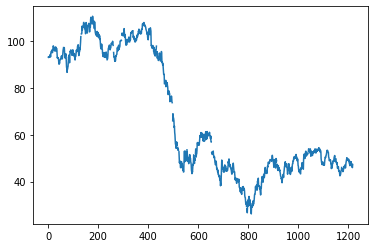

In [15]:
plt.plot(oil['dcoilwtico'])
plt.show()

- 국제 유가 가격이 중반기부터 뚝 떨어짐

## store

city, state, type, cluster이 있음
- cluster은 비슷한 가게들끼리 모은 것임

In [16]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [17]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


데이터 수가 매우 적음
- 결측치는 없어 보임
- data형은 없고 store_nbr과 cluster외에는 문자형임

### store_nbr

In [18]:
stores['store_nbr'].value_counts()

1     1
41    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
42    1
2     1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
29    1
28    1
27    1
26    1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
54    1
Name: store_nbr, dtype: int64

store_nbr은 가게 숫자임, index랑 비슷함

### city

In [19]:
stores['city'].value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

Quito가 가장 많고 그 다음 Guayaquil, 그 외에는 data수가 매우 적음

- 전처리가 필요함

### state

In [20]:
stores['state'].value_counts()

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: state, dtype: int64

마찬가지로 Pichincha와 Guayas 외에는 data수가 매우 적음
- 전처리 필요

### type

In [21]:
stores['type'].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

다른 특성에 비해 균일함

### cluster

In [22]:
stores['cluster'].value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

다른 특성에 비해 균일하지만 그래도 적은 data값이 보임

## train

In [23]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [24]:
train.info(null_counts=True)

<ipython-input-24-44357f989048>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  train.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3000888 non-null  int64  
 1   date         3000888 non-null  object 
 2   store_nbr    3000888 non-null  int64  
 3   family       3000888 non-null  object 
 4   sales        3000888 non-null  float64
 5   onpromotion  3000888 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


결측치 없고 data수가 가장 많음

- train에 나머지 holidays_events, oil, store 등의 csv파일을 date 기준으로 합쳐야 할듯

### store_nbr

In [25]:
train['store_nbr'].value_counts()

1     55572
46    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
47    55572
10    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
35    55572
34    55572
33    55572
32    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
9     55572
Name: store_nbr, dtype: int64

55572로 균일함

### family

In [26]:
train['family'].value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

90936으로 균일함

### sales

In [27]:
train['sales'].describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

실수형이기 때문에 추가 분석이 필요함

- box plot으로 구역별, date별로 확인해보겠음

### onpromotion

In [28]:
train['onpromotion'].value_counts()

0      2389559
1       174551
2        79386
3        45862
4        31659
        ...   
313          1
452          1
642          1
305          1
425          1
Name: onpromotion, Length: 362, dtype: int64

In [29]:
train['onpromotion'].value_counts().sort_index()

0      2389559
1       174551
2        79386
3        45862
4        31659
        ...   
719          1
720          1
722          1
726          1
741          1
Name: onpromotion, Length: 362, dtype: int64

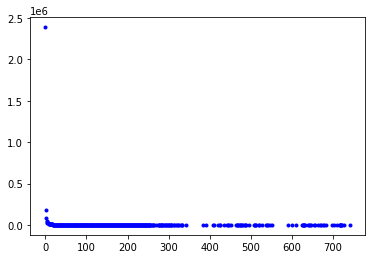

In [30]:
plt.plot(train['onpromotion'].value_counts().sort_index(),'b.')
plt.show()

내림차순으로 data가 분배된듯함

- 전처리가 필요

# EDA

In [31]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


## date를 연도, 월, 일로 분리

In [32]:
from tqdm import tqdm

In [33]:
train['year'] = None
train['month'] = None
train['day'] = None

In [34]:
train

,id,date,store_nbr,family,sales,onpromotion,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,None,None,None
1,1,2013-01-01,1,BABY CARE,0.000,0,None,None,None
2,2,2013-01-01,1,BEAUTY,0.000,0,None,None,None
3,3,2013-01-01,1,BEVERAGES,0.000,0,None,None,None
4,4,2013-01-01,1,BOOKS,0.000,0,None,None,None
...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,None,None,None
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,None,None,None
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,None,None,None
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,None,None,None


In [35]:
train_hun = pd.read_csv('./drive/MyDrive/All_in_kaggle/store-sales-time-series-forecasting/train_hun.csv')

In [36]:
train_hun

,id,date,store_nbr,family,sales,onpromotion,year,year-month,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,2013-01,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,2013-01,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,2013-01,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,2013-01,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,2017-08,8,15
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,2017-08,8,15
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,2017-08,8,15
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,2017-08,8,15


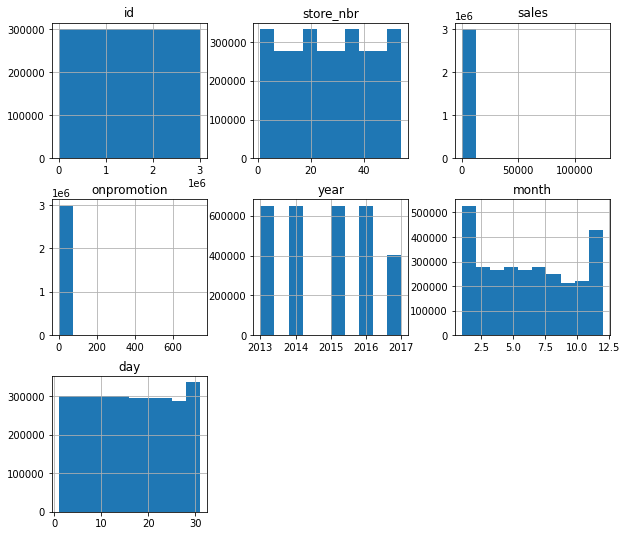

In [37]:
train_hun.hist(figsize=(10,9))
plt.show()

In [38]:
# date, id 행 삭제
train2 = train_hun.drop(["id","date"],axis=1)

## boxplot

### year

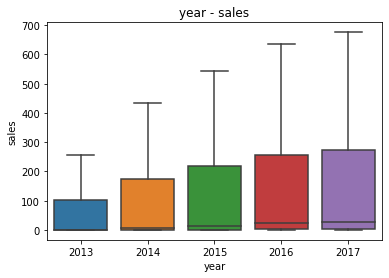

In [39]:
g = sns.boxplot(x="year",y="sales",data=train2,showfliers=False)
g.set_title('year - sales')
plt.show()

- 년도가 올라갈수록 sales가 증가함

### month

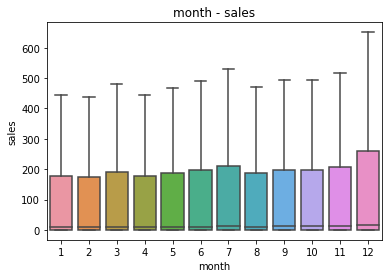

In [40]:
g = sns.boxplot(x="month",y="sales",data=train2,showfliers=False)
g.set_title('month - sales')
plt.show()

- 비슷해 보임
- 년도+월별로 분석이 필요함

### year+month

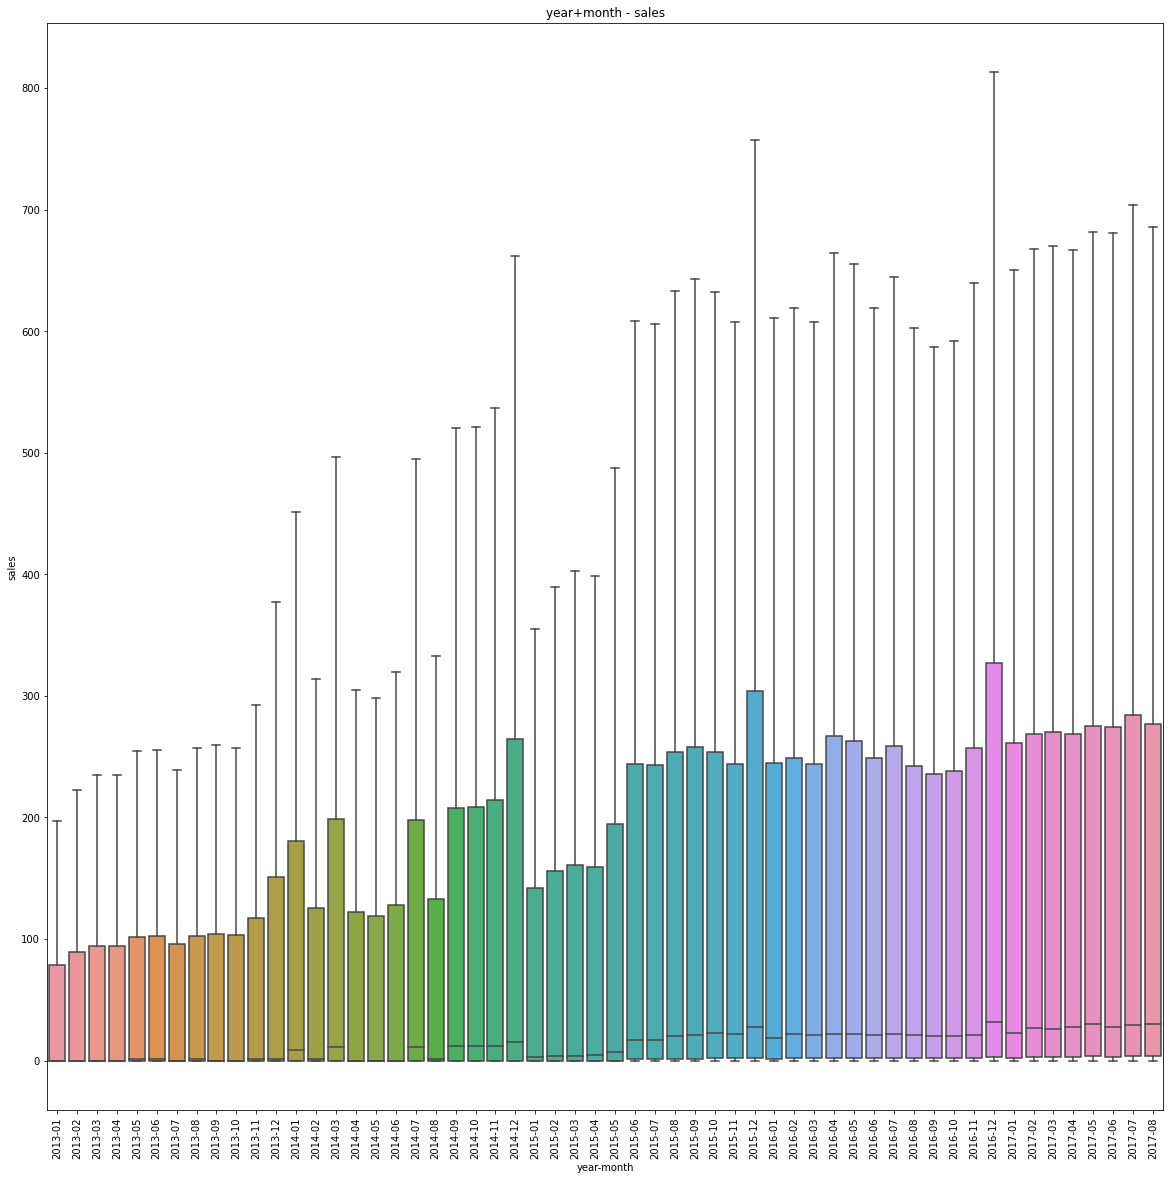

In [41]:
plt.figure(figsize=(20,20))
g = sns.boxplot(x="year-month",y="sales",data=train2,showfliers=False)
g.set_title('year+month - sales')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

- 12월에 sales가 급격히 상승, 1월에 급격히 하강

### store_nbr

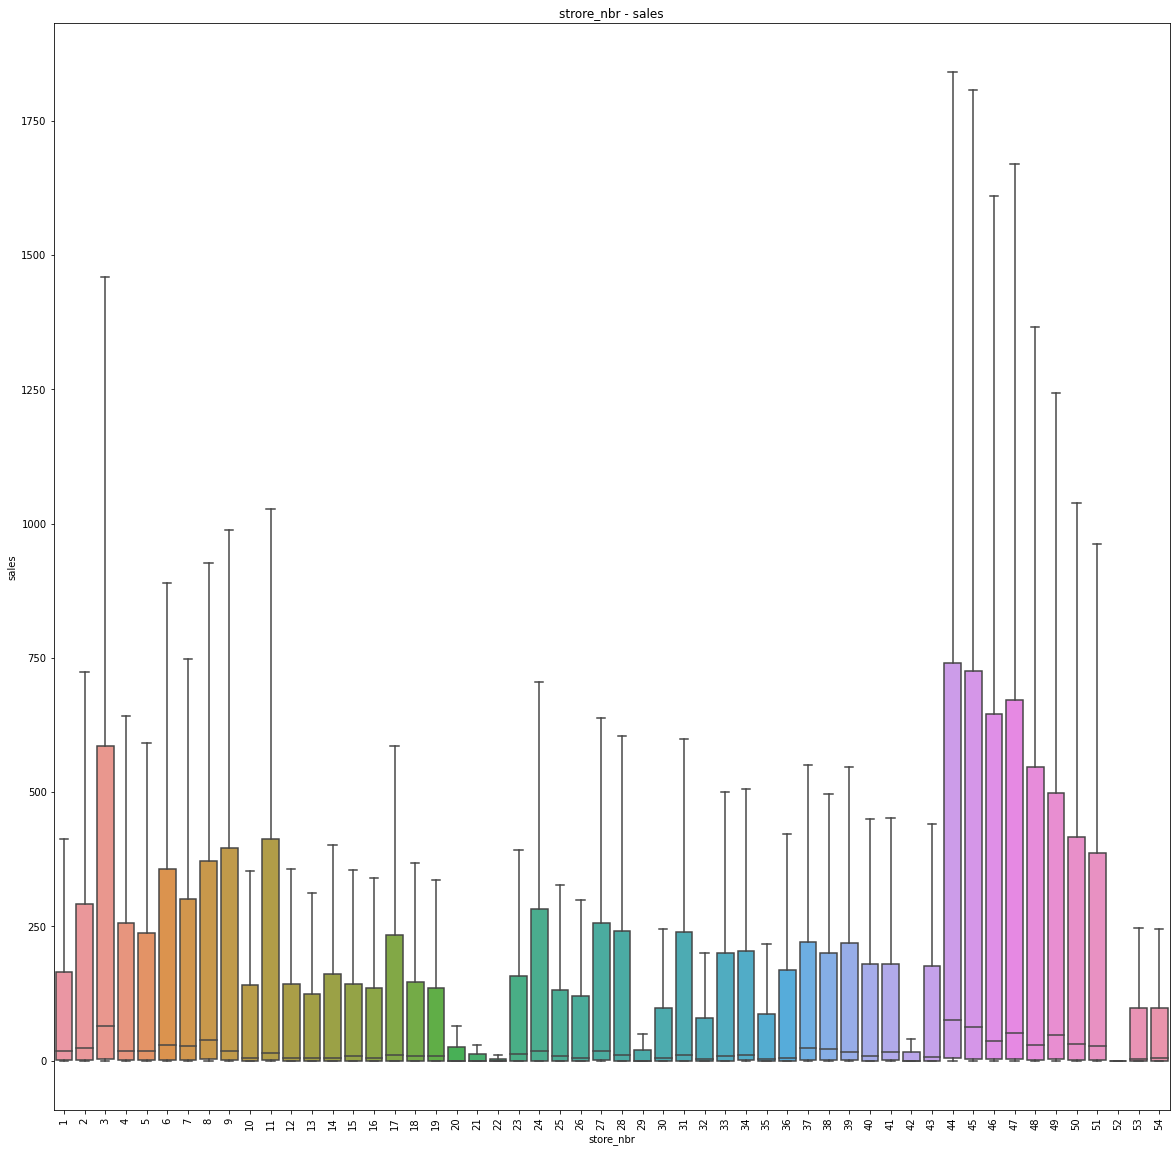

In [42]:
plt.figure(figsize=(20,20))
g = sns.boxplot(x="store_nbr",y="sales",data=train2,showfliers=False)
g.set_title('strore_nbr - sales')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

### day

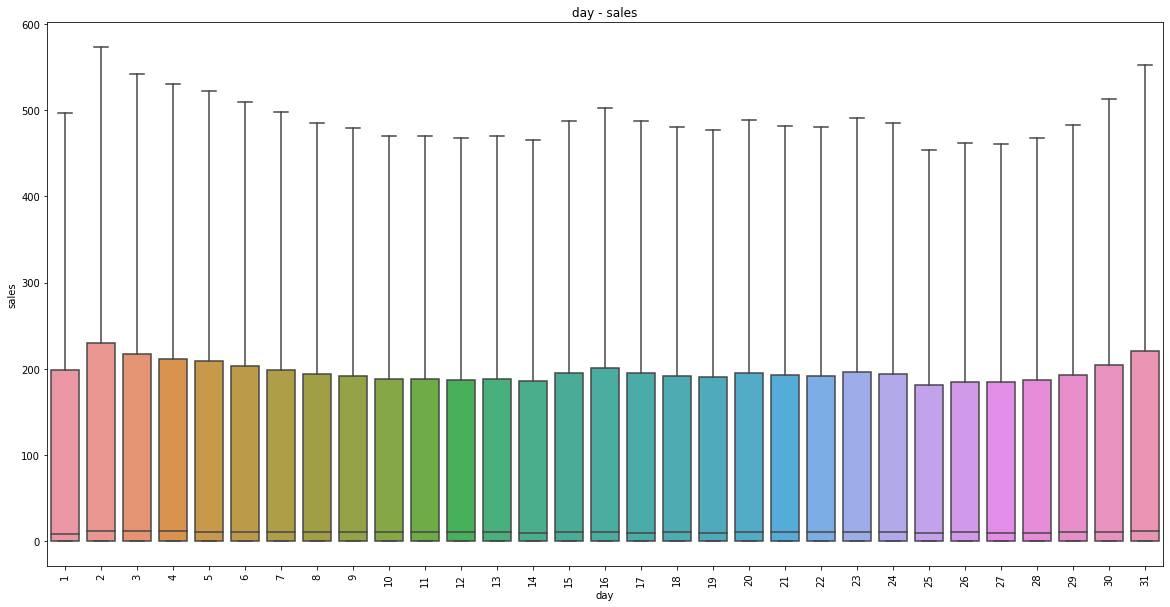

In [43]:
plt.figure(figsize=(20,10))
g = sns.boxplot(x="day",y="sales",data=train2,showfliers=False)
g.set_title('day - sales')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

### onpromotion

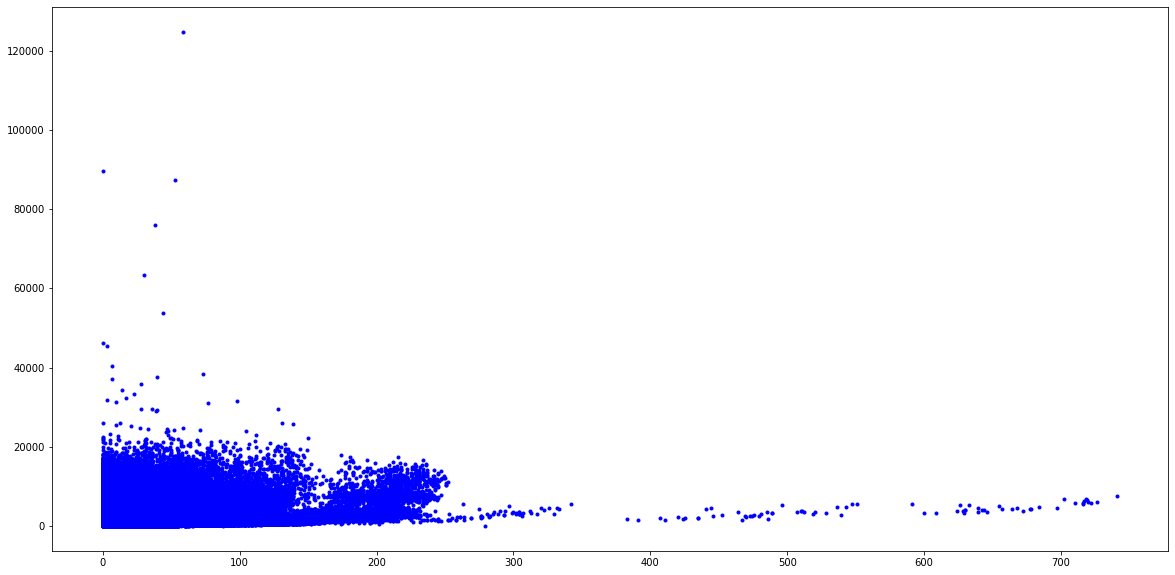

In [44]:
plt.figure(figsize=(20,10))
plt.plot(train2['onpromotion'],train2['sales'],'.b')
plt.show()

- 제일 관계 없어 보임

## 다른 csv파일과 합치기

### holiday.csv 파일 

In [45]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [46]:
holidays_events['year']=holidays_events.date.dt.year
holidays_events['year-month']=holidays_events['date'].apply(lambda x:x.strftime('%Y-%m'))
holidays_events['month']=holidays_events.date.dt.month
holidays_events['day']=holidays_events.date.dt.day
holidays_events

,date,type,locale,locale_name,description,transferred,year,year-month,month,day
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,2012-03,3,2
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,2012-04,4,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,2012-04,4,12
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,2012-04,4,14
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,2012-04,4,21
...,...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,2017-12,12,22
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,2017-12,12,23
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,2017-12,12,24
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,2017,2017-12,12,25


## 상관계수